In [19]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
classes=('penis','vagina','breast','butt','naked-body','naked-bottom','underwear','bra','hand','dildo','cum','tongue')
classes=('penis','vagina','breast','butt','naked-body','naked-bottom','underwear','bra','dildo','cum')


In [56]:

## config_file = '../configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
config_file = '../configs/censor/faster_rcnn_x101_32x4d_fpn_1x_censor.py'
config_file = '../configs/censor/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1-coloraug.py'
config_file = '../configs/censor/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
#checkpoint_file = '../checkpoints/faster_rcnn_r50_fpn_1x_20181010-3d1b3351.pth'
checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor/epoch_17.pth'
checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor-rot/epoch_29.pth'
checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1-coloraug/epoch_25.pth'
checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1/epoch_20.pth'
#checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s4/epoch_48.pth'
#checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor/epoch_20.pth'

config_file = '../configs/censor/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1.py'
checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1/epoch_38.pth'
checkpoint_file = '../work_dirs/class12/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1/epoch_34.pth'
checkpoint_file = '../work_dirs/faster_rcnn_x101_32x4d_fpn_1x_censor-freeze-s1/epoch_27.pth'
model = init_detector(config_file, checkpoint_file, device='cuda:1')

two_stage.py: pretrained=  None


In [46]:
# build the model from a config file and a checkpoint file

lines = open('/home/jovyan/fast-data/tusou_test/script/valid.lst','r').readlines()
PORN6=['hentai','anime','norm','porn','sexy','very_sexy']
dat={}
print(len(lines))
for line in lines:
    a = line.rstrip().split(' ')
    file = a[0]
    annt = PORN6[int(a[1])]
    if annt not in dat.keys():
        dat[annt]=[]
        dat[annt].append(file)
    else:
        dat[annt].append(file)
#print(dat)
test_data= dat
print(test_data.keys())

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/fast-data/tusou_test/script/valid.lst'

In [64]:
import cv2
import os
import json
#lines = open('../data/censor/test/abby_fc2_test.txt').readlines()
#lines = open('../data/censor/test/fc2_photos.txt').readlines()
# lines = open('/home/shengtao/Data/tusou_test/tusou_1.txt').readlines()
# test_data={}
# for line in lines:
#     img_path = line.rstrip('\n')
#     img_tag = img_path.split('/')[-2]
#     if img_tag  not in test_data.keys():
#         test_data[img_tag]=[img_path]
#     else:
#         test_data[img_tag].append(img_path)
# print(test_data.keys())
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm

def get_test_data(fpath):
    lines = open(fpath).readlines()
    test_data={}
    for line in lines:
        img_path = line.rstrip('\n')
        img_tag = img_path.split('/')[-2]
        if img_tag  not in test_data.keys():
            test_data[img_tag]=[img_path]
        else:
            test_data[img_tag].append(img_path)
    print(test_data.keys())
    return test_data

def check_result(result,thr):
    checkList = [0,1,2,3,4,5,6,7,9,10,11] # without hand
    for i in checkList:
        if result[i].shape[0]>0:
            for j in range(result[i].shape[0]):
                if result[i][j,4]>=thr:
                    return True
    return False

def draw_rects(imageFile,ret,thre=0.3, classes_name=''):
    #print(len(ret))
    if classes_name == '':
        classes=( 'penis', 'vagina','breast', 'butt','naked-body', 'naked-bottom', 'underwear','bra','hand','dildo','cum','tongue')
    else:
        classes = classes_name
    #print(len(classes))
    img = cv2.imread(imageFile)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #bb = an['bbox']
    for i in range(12):
        #print(ret[i])
        if ret[i].shape[0] == 0:
            continue
        else:
            for j in range(ret[i].shape[0]):
                
                bb = ret[i][j,:]
                #print(bb)
                pt1= (int(bb[0]),int(bb[1]))
                pt2=(int(bb[2]), int(bb[3]))
                conf = bb[4]
                if conf <thre:
                    continue
                img=cv2.rectangle(img,pt1,pt2,(255,0,0),3)
                img=cv2.putText(img,classes[i]+' | %.2f'%conf,pt1, cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
    #print('done')
    return img
def test_list(model,fpath, saveRoot='/home/shengtao/Data/coco/ret/',thr=0.3, saveAllPos=False,saveAllNeg=False):
    if not os.path.exists(saveRoot):
        os.mkdir(saveRoot)
    test_data = get_test_data(fpath)
    testKeys = list(test_data.keys())
    fid = open(fpath+'_ret.json','w')
    retDat = {}

    for tag in tqdm(testKeys):
        #count = count+1
        if tag not in retDat.keys():
            retDat[tag]={}
        #for imgfile in tqdm(test_data[tag]):
        for imgfile in test_data[tag]:    
            try:
                result = inference_detector(model, imgfile)
                ret = check_result(result,thr)
                cat = imgfile.split('/')[-2]
                if saveAllPos:
                    if ret:
                        img = draw_rects(imgfile,result,thr,classes_name=classes)
                        
                        cv2.imwrite(saveRoot+'%d_'%ret+cat+'_'+imgfile.split('/')[-1].split('.')[0]+'.jpg',img)  
                if saveAllNeg:
                    if not ret:
                        img = draw_rects(imgfile,result,thr,classes_name=classes)
                
                        cv2.imwrite(saveRoot+'%d_'%ret+cat+'_'+imgfile.split('/')[-1].split('.')[0]+'.jpg',img)                          
                retDat[tag][imgfile]={}
                for ij in range(10):
                    #print(result[ij])
                    crtClass = classes[ij]
                    retDat[tag][imgfile][crtClass]=[]
                    for ix in range(result[ij].shape[0]):
                        #retDat[tag][imgfile][crtClass].append(list(result[ij][ix]))
                        crtRet=result[ij][ix].tolist()
                        retDat[tag][imgfile][crtClass].append(crtRet)
            except:
                print(imgfile+' failed')
                retDat[tag][imgfile]=[]
                fid.write(imgfile+' 0\n')
                continue
    #print(retDat)            
    json.dump(retDat,fid,indent=4)
    fid.close()
    return retDat
#test_list(model,'/home/shengtao/Data/tusou_test/fc2_failed_photo.txt')
#saveRoot = '/home/shengtao/Data/tusou_test/tusou_3_ret/'
#retDat = test_list(model,'/home/shengtao/Data/tusou_test/tusou_3.txt',saveRoot,thr=0.5,saveAllPos=True,saveAllNeg=True)
#test_list(model,'/home/shengtao/Data/coco/coco.txt')
#testFile = '/home/shengtao/Data/censor_dat/test/fc2_videos/fc2_video_2012.txt'
#retDat = test_list(model,testFile,saveRoot='./',thr=0.5,saveAllPos=False,saveAllNeg=False)
testFile = '/home/shengtao/Data/censor_dat/test/fc2_videos/fc2_video_2013.txt'
retDat = test_list(model,testFile,saveRoot='./',thr=0.5,saveAllPos=False,saveAllNeg=False)
#testFile = '/home/shengtao/Data/censor_dat/test/fc2_videos/fc2_video_2014.txt'
#retDat = test_list(model,testFile,saveRoot='./',thr=0.5,saveAllPos=False,saveAllNeg=False)
testFile = '/home/shengtao/Data/censor_dat/test/fc2_videos/fc2_video_2015.txt'
retDat = test_list(model,testFile,saveRoot='./',thr=0.5,saveAllPos=False,saveAllNeg=False)
#testFile = '/home/shengtao/Data/censor_dat/test/fc2_videos/fc2_video_2017.txt'
#retDat = test_list(model,testFile,saveRoot='./',thr=0.5,saveAllPos=False,saveAllNeg=False)
testFile = '/home/shengtao/Data/censor_dat/test/fc2_videos/fc2_video_2018.txt'
retDat = test_list(model,testFile,saveRoot='./',thr=0.5,saveAllPos=False,saveAllNeg=False)

  0%|          | 0/6728 [00:00<?, ?it/s]

dict_keys(['153379', '162535', '129545', '141661', '141807', '134737', '158863', '98928', '157167', '117606', '131222', '143746', '162221', '140251', '104397', '161120', '146386', '122779', '161874', '143337', '154416', '112597', '114726', '161939', '139310', '91453', '107235', '144257', '102136', '134031', '106468', '143001', '106236', '128630', '139555', '141634', '138817', '148097', '129330', '151980', '108808', '156369', '110831', '113807', '135385', '106722', '161374', '147550', '163399', '108379', '151702', '155309', '107840', '110334', '97962', '135414', '151096', '164625', '164618', '129517', '155384', '143408', '104154', '160999', '106632', '121091', '143507', '162523', '143365', '126582', '161820', '143410', '156426', '157879', '149342', '149718', '100168', '147351', '100593', '111330', '140684', '132119', '116252', '126031', '162796', '162985', '108292', '145271', '152500', '119203', '162211', '165707', '112062', '139001', '162679', '161108', '145570', '106151', '132186', '1

  0%|          | 0/13954 [00:00<?, ?it/s]

dict_keys(['364115', '364109', '364089', '1258151', '364085', '364084', '364078', '364077', '364070', '364052', '905745', '572182', '364047', '364004', '364072', '364035', '364043', '364001', '364025', '363985', '363975', '363959', '363988', '363962', '363976', '363997', '363990', '363966', '364020', '363979', '363956', '363927', '363964', '363957', '363963', '363958', '363960', '363965', '363920', '363917', '363967', '363952', '363941', '363913', '363954', '363948', '363907', '363921', '363878', '363925', '363916', '363803', '363915', '363861', '363919', '363881', '363874', '363858', '363912', '363884', '363876', '363914', '363715', '363854', '363846', '363838', '363851', '363860', '363835', '361693', '363845', '363828', '363891', '363842', '361707', '363863', '363856', '363850', '363811', '363836', '363852', '363823', '363809', '363834', '361699', '363855', '363839', '363801', '363853', '363816', '361692', '363825', '363810', '363841', '363826', '361696', '363806', '363831', '363814'

  0%|          | 0/7945 [00:00<?, ?it/s]

dict_keys(['980582', '997467', '999046', '997961', '989329', '986452', '1001432', '984002', '994292', '983087', '992645', '989353', '996468', '1001057', '1000130', '975249', '975876', '1002312', '996940', '979625', '980471', '997262', '982770', '994701', '977537', '990102', '993368', '1003309', '999829', '1003048', '1003798', '987843', '1003590', '994378', '1001476', '975347', '977618', '1002792', '991921', '1001245', '984734', '974338', '995869', '1001692', '996133', '991826', '1002856', '980719', '993990', '975410', '980534', '1004204', '994801', '985195', '984898', '983413', '990133', '997654', '1001485', '990456', '994844', '1002823', '985061', '1000341', '997680', '996309', '975571', '997892', '978624', '978625', '994011', '1001546', '974775', '975016', '974626', '982575', '993707', '978681', '999795', '986488', '995580', '996769', '975279', '975359', '986618', '997063', '984109', '997526', '977071', '1004131', '976410', '999036', '988711', '981792', '986844', '988125', '995679', 

100%|██████████| 7945/7945 [1:39:16<00:00,  1.33it/s]


In [63]:
import random
import shutil
def move_sel_test_to_train(test_data):
    tags=['Wet_pussy','Anus_asshole','Cream_pie','Meaty_lips','Anal_dildo','Clitoris_close_up','Dildo_in_pussy','Fingering','Fisting','Blowjob','Hairy_pussy_close_up','Natural_hairy_bush','Nip_slip','Nipple_to_nipple','Pee_porn','Shot_from_below','Wet_pussy']
    dats=[]
    for tag in tags:
        print(tag, len(test_data[tag]))
        random.shuffle(test_data[tag])
        dats = dats+test_data[tag][:int(len(test_data[tag])*0.2)]
    random.shuffle(dats)
    print(len(dats))
    for img in dats[:500]:
        newPath = '/home/shengtao/Data/censor_dat/test/abby_train/'+img.split('/')[-1]
        print(img,newPath)
        shutil.copyfile(img,newPath)
        
#move_sel_test_to_train(test_data)
print(0)

0


/home/shengtao/Data/censor_dat/test/abbywinter/Meaty_lips/candice250-med.jpg


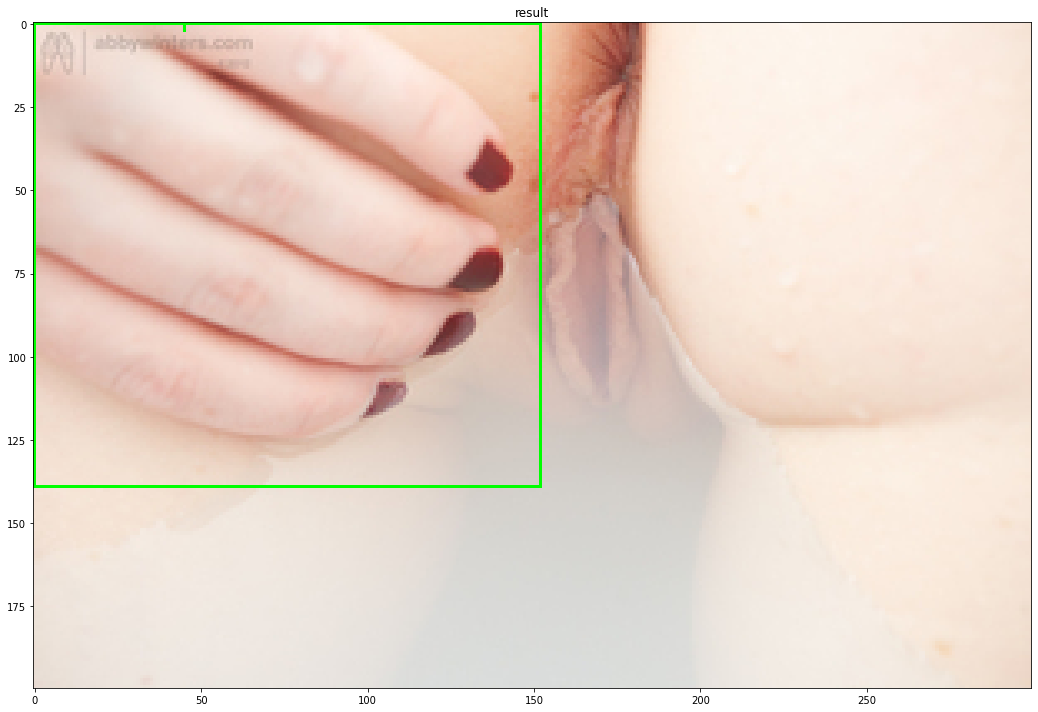

In [27]:
# test a single image
import cv2
img = 'demo.jpg'
img = '/home/jovyan/fast-data/tusou_test/porn/(m=bJ4hdaaecaa)(mh=-EDlnUGRnKxMCZ-J)original_208989461.jpg'
for imgfil in test_data['Meaty_lips'][:100]:
    img_bgr = cv2.imread(imgfil)
    #print(imgfil)
    img_rgb=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    #result = inference_detector(model, img_bgr)
    result = inference_detector(model, imgfil)
    if not check_result(result):
    #print(result)
        print(imgfil)
        show_result_pyplot(model, imgfil, result,score_thr=0.3)

In [6]:
import cv2
img = 'demo.jpg'
img = '/home/jovyan/fast-data/tusou_test/porn/(m=bJ4hdaaecaa)(mh=-EDlnUGRnKxMCZ-J)original_208989461.jpg'
imgList = []
count = 0
testKeys = list(test_data.keys())
for tag in testKeys:
    #tag = 'Meaty_lips'
    for imgfile in test_data[tag]:
        count = count+1
        #img_bgr = cv2.imread(imgfil)
        #img_rgb=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        try:
            result = inference_detector(model, imgfile)
        except:
            continue
        if not check_result(result):
            print(imgfile)
            imgList.append(imgfile)
print(count, len(imgList))
fid = open('./test_failed_fc2_photos.txt','w')
for x in imgList:
    fid.write(x+'\n')
fid.close()

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/864351/1529740052.85.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/864351/1529740051.89.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/864351/1529740050.32.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/860630/1529353491.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/950652/1539147271.51.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/934791/1537410527.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/934791/1537410527.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/928963/1536843848.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/898398/1533559306.24.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/898398/1533559306.49.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/898398/1533559306.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/898398/1

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/977470/1542045524.6.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/773033/1518665272.73.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/826647/1525418834.27.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/826647/1525418803.28.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/943213/1538334412.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/943138/1538328766.79.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/916044/1535531837.19.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/931197/1537034853.81.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/931197/1537034853.3.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/931197/1537034854.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/931197/1537034849.71.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/994549/

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/966716/1540893712.64.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/886946/1532317430.99.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/985586/1589586806.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/911036/1535029715.35.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/911036/1535029714.19.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/948017/1609825112.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/901554/1533906170.48.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/785899/1520389921.79.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/859624/1529241544.5.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/791490/1521051191.44.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/791490/1521051205.7.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/801750/

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/944227/1538466978.46.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/944227/1538466979.39.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/944227/1538466979.05.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/889219/1532538322.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/889219/1532538324.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/889219/1532538328.53.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/782686/1519968574.2.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/782686/1519968573.59.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/782686/1519968574.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/938750/1537813316.25.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/938750/1537813312.15.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/895258

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/852620/1496461388.16.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/858479/1529085704.33.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/858479/1529085709.45.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/939398/1537889243.78.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/934567/1537376464.87.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/934567/1537376465.11.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/934567/1537376466.56.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/907934/1534654909.04.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/907934/1534654908.79.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/907934/1534654906.37.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/907934/1534654907.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/88910

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/934272/1537350305.17.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/860569/1529344295.46.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/791299/1521028235.19.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/791299/1521028232.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/916004/1535530373.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/804138/1522662361.9.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/971978/1541497771.48.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/772611/1518604563.22.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/772611/1518604568.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/772611/1518604563.83.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/772611/1518604565.36.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/934584

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/807306/1523019905.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/807306/1523019906.36.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/806866/1522990530.36.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/806866/1522990531.51.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/806866/1522990529.36.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/997394/1544597563.8.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/997394/1544597561.77.s4x001.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/769376/1518188659.76.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/769376/1518188654.41.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/769376/1518188653.45.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/769376/1518188652.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/883101/1531885775.32.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/883101/1531885775.81.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/834341/1526294945.13.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/834341/1526294940.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/874558/1530876951.03.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/874558/1530876951.29.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/804202/1522666350.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/773030/1518665050.68.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/942839/1540211830.58.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/804210/1522405024.6.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/804210/1522405037.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/896926

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/765586/1517738634.48.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/910554/1534949785.8.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/850685/1528265575.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/753595/1516261302.7.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/753595/1516261343.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/875942/1531043880.65.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/887694/1532375600.95.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/869152/1530274736.18.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/776873/1519179021.34.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/852245/1528436003.79.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/760572/1517083075.33.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/761368/1

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/865304/1529839242.6.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/787348/1520544701.15.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/934618/1537384032.76.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/883121/1531885893.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/883121/1531885892.17.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/883121/1531885891.48.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/886108/1532191196.77.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/885883/1532170012.27.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/885883/1532170011.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/885883/1532170012.83.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/903853/1534181453.7.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/901572/

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/938745/1537813020.87.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/888112/1532425713.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/931156/1537028628.65.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/931156/1537028627.69.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/942923/1608835933.98.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/942923/1608835915.22.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/959740/1540091990.07.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/784292/1520162108.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/784292/1520162108.37.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/815721/1524055215.53.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/771884/1518514807.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2018/75063

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/292558/1426085071.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/286581/1423862061.61.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/305697/1431314488.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/305385/1431139062.04.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/277956/1420791462.49.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/299546/1428704202.68.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/326950/1439395252.68.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/326950/1439395252.39.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/291244/1425588774.25.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/289436/1424924535.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/304533/1430774708.64.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/30429

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/319684/1436352968.01.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/333506/1441856800.49.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/288465/1424514737.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/314449/1434511033.7.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/304299/1430693124.1.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/364015/1450838752.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/289904/1425069863.26.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/308402/1432333842.01.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/308402/1432333851.17.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/358428/1448469800.21.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/362212/1450143706.74.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/362212/

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/324122/1441216505.85.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/324122/1441216603.19.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/324122/1441216495.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/302768/1429919956.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/1623528/1609902883.44.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/1623528/1609902883.44.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/307639/1432081805.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/307639/1432081803.88.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/290096/1425157944.78.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/300685/1429132077.77.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/309797/1432911285.5.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/3097

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/338866/1444090018.26.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/278105/1420837320.82.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/279993/1421486812.23.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/299241/1428622804.14.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/356615/1447788180.05.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/319669/1436343735.94.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/337051/1442985450.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/276456/1420277151.55.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/363808/1450750719.78.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/363808/1450750705.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/363808/1450750703.13.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2015/27645

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1024785/1548674309.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1115255/1561744271.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1115255/1561744259.75.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1115255/1561744266.45.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1115255/1561744262.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1121013/1562576945.07.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1220466/1575953629.69.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1220466/1575953631.49.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1220466/1575953631.03.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1220466/1575953629.42.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1189982/1572270928.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_20

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1078402/1556738506.76.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1108545/1560863023.15.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1033195/1549964588.55.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1129197/1563768146.3.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1213711/1575132628.53.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1193182/1572675317.05.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1082938/1557392530.19.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1138614/1565175435.04.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1138614/1565175437.38.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1175757/1570365085.37.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1158043/1567925026.57.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1143528/1565873879.02.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1143528/1565873331.21.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1223735/1576318750.28.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1187696/1573641431.98.96.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1226641/1576669677.79.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1118429/1562219263.36.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1118429/1562219262.99.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1172537/1569930942.37.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1135473/1564729525.58.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1177664/1570662235.76.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1225602/1576561049.69.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samp

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1195160/1572944380.44.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1195160/1572944219.5.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1195160/1572944359.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1193202/1572677755.71.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1193202/1572677755.29.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1193202/1572677756.23.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1193202/1572677754.32.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1193202/1572677755.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1160676/1568336963.91.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1219564/1575838104.53.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1219564/1575838103.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1016574/1523603405.95.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1162880/1568618497.68.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1023524/1609956376.02.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1176952/1570545925.35.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1209132/1574586933.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1209132/1574586936.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1025097/1548730008.55.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1197423/1573223357.21.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1177711/1570671416.38.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1177711/1570671448.27.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1177711/1570671447.93.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1141057/1565514379.34.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1031053/1549620972.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1170587/1569668300.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1118425/1562219057.87.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1022335/1548314697.59.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1193083/1572666695.54.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1227663/1576801146.45.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1227663/1576801174.07.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1227663/1576801151.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1167964/1598086674.06.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1167964/1598086678.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1115912/1561823893.46.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1179307/1570869844.98.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1221337/1576055367.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1221337/1576055343.27.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1047512/1552136385.28.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1220456/1575951631.59.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1116584/1561950228.22.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1144712/1587109030.13.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1144712/1587109043.88.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1144712/1598086333.73.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1141501/1565590033.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1221200/1576041057.99.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1195152/1572943682.03.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1095545/1559046901.24.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1095545/1559046897.97.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1095545/1559046902.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1096895/1559215943.03.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1203902/1573994559.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1203902/1573994497.18.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1176891/1570541402.46.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1176891/1570541416.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1036580/1550461594.26.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1047596/1552142032.43.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1047596/1552142030.1.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1030411/1549537658.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1131692/1564140888.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1131692/1564140887.93.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1131692/1564140822.83.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1170661/1569673233.33.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1170661/1569673229.73.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1144370/1565974142.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1144370/1565974182.49.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2019/1144370/1565974157.76.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_201

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/727175/1513011022.22.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/727175/1513011001.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/559628/1494065815.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/559628/1494065814.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/559628/1494065813.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/546797/1492514953.41.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/549629/1492840217.29.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/549629/1492840217.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/549629/1492840216.73.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/544329/1492231951.28.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/544329/1492231950.56.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/726004/1512

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/550935/1493022687.71.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/550935/1493022687.24.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/524974/1489767435.04.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/544867/1492293001.7.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/544867/1492293001.46.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/595274/1498276680.96.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/509181/1487290455.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/509181/1487290469.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/714385/1511520320.8.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/714385/1511520319.97.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/714385/1511520323.79.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/527214/

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/621508/1501169791.74.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/648224/1497521934.68.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/612445/1498276877.7.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/612445/1498276877.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/582901/1496820430.37.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/582901/1496820430.61.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/684725/1508401196.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/534106/1491030980.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/636351/1502870845.32.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/637062/1502939097.35.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/571532/1495447341.23.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/527209

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/558886/1493994053.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/558886/1493994052.7.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/618988/1500899676.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/618988/1500899666.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/509741/1477287033.91.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/511639/1487398512.25.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/511639/1487398479.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/596979/1498512568.71.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/596979/1498512570.99.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/544854/1492259125.05.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/630633/1502204634.68.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/630633

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/488167/1483543454.8.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/488167/1483543454.51.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/488167/1483543454.24.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/584529/1496993873.85.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/519008/1488854870.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/519008/1488854873.74.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/677376/1507602504.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/529200/1490381419.38.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/712544/1511332451.58.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/502469/1486172430.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/649159/1504196503.1.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/644506/150

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/567845/1495079855.55.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/492556/1484356367.61.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/492556/1484356368.95.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/492556/1484356368.34.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/560073/1494137445.79.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/560073/1494137445.59.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/560073/1494137446.49.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/700644/1510121119.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/496470/1485058153.29.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/677100/1507557153.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/688980/1508850166.39.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/68898

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/610659/1500022467.17.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/544850/1477287033.91.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/595909/1498357596.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/595909/1498357595.36.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/595909/1498357594.89.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/527211/1490121096.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/527211/1490121081.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/658027/1477287033.91.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/520013/1487393739.03.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/520013/1487391186.88.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/520013/1487393731.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2017/53676

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/112763/1368343405.1.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/105274/1364262543.69.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/103437/1363234606.24.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/106838/1365094579.51.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/125112/1374247543.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/107925/1365715387.02.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/103658/1363352285.8.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/129220/1375709700.46.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/110886/1367404042.33.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/110886/1367404031.41.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/98876/1360839054.02.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/98876/13

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/157892/1385248345.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/151602/1383098638.39.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/113532/1368779336.93.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/158837/1385585208.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/102904/1362965353.69.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/159085/1385674944.41.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/99529/1361178357.77.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/99529/1361178353.69.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/109285/1366519114.07.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/129279/1375738919.3.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/128881/1375580794.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/95283/13

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/98408/1360570359.38.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/161142/1386311112.03.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/111135/1367499162.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/96430/1359635510.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/96430/1359635510.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/102560/1362794461.01.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/102560/1362794461.49.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/102560/1362794462.01.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/102560/1362794463.39.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/98198/1360477217.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/163258/1386972698.15.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/102156/13

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/98302/1360504722.16.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/143887/1380768054.78.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/128097/1375311643.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/128097/1375311646.6.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/154421/1384062310.06.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/101912/1362453355.95.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/105870/1364547901.59.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/107805/1365613022.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/99300/1361061342.16.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/131894/1376696920.88.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/131894/1376868527.98.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/109932/1

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/114586/1369276136.26.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/95922/1359357096.82.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/152789/1383466386.32.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/144608/1380969507.3.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/144608/1380969505.16.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/107543/1365467063.36.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/107524/1365443494.65.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/158424/1385441247.57.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/158424/1385441248.91.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/110994/1367445599.61.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/100791/1361871296.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/107522/

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/135796/1378160057.68.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/102235/1362613020.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/104680/1363924256.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/101205/1362100390.33.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/132708/1377050763.07.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/132708/1377050766.06.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/111781/1367792383.29.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/106862/1365122459.19.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/117766/1370953880.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/102501/1362765920.9.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/102501/1362765922.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/102501/1

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/111483/1367650535.98.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/111483/1367650521.8.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/104795/1364001549.75.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/112593/1368260042.49.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/97956/1360372592.87.ai.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/97956/1360372593.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/161615/1386440281.93.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/96873/1359868633.75.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/129491/1375834354.25.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/136037/1378218648.34.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/115644/1369820702.65.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/142789

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/151100/1382927809.42.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/143873/1380765799.02.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/143873/1380765798.7.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/98595/1360669079.69.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/112780/1368350193.64.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/112780/1369932174.24.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/111201/1367534944.59.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/112718/1368323746.8.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/102272/1362628632.11.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/102272/1362628632.87.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/102272/1362628635.36.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/102272/1

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/103413/1363230741.36.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/103413/1363230739.87.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/105482/1364361317.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/122229/1372988595.35.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/116780/1370487544.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/108093/1365790718.1.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/112700/1368312668.81.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/110015/1366988052.87.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/110015/1366988053.78.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/110015/1366988127.06.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/101439/1362212668.89.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/101439

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/95317/1359065659.91.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/164585/1387402815.17.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/141452/1380076263.85.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/144343/1380904344.94.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/128108/1375321691.28.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/125063/1374237657.27.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/125063/1373808138.33.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/127642/1375150097.54.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/159836/1385879574.05.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/159836/1385879575.61.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/145523/1381242641.57.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/152708

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/105570/1364390540.3.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/101202/1362094357.51.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/152782/1383465678.21.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/93499/1358222875.06.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/106970/1365177297.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/113528/1368778302.07.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/113528/1368778294.1.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/141694/1380149756.68.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/156857/1384899574.53.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/156857/1384899575.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/105275/1364262717.36.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2013/116524/13

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1509878/1600672073.05.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1509878/1600672202.21.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1509878/1600672173.21.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1602266/1607657218.29.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1575270/1605747086.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1348890/1587818890.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1322584/1585826719.78.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1322584/1585826712.5.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1508166/1600529631.96.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1372093/1589538619.26.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1372093/1589538622.55.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_202

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1524686/1601950064.22.avi_20201006_110015.361.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1473153/1597615146.18.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1473153/1597615147.42.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1473153/1597615138.27.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1473153/1597615146.8.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1473153/1597615146.35.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1473153/1597615145.89.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1473153/1597615146.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1473153/1597615147.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1446915/1595580733.65.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1446915/1595580731.8.jpg
/home/shengtao/Data/censor_dat/t

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1605204/1607837715.8.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1587927/1606601375.27.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1516025/1601178012.34.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1516025/1601177988.68.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1533413/1602610265.21.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1533413/1602610264.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1533413/1602610264.94.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1516827/1601256122.95.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1560950/1604690563.64.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1264109/1580652256.64.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1574127/1605649895.41.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1392417/1591159458.01.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1569892/1605332732.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1352082/1588077540.51.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1352082/1588077458.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1382577/1590350488.03.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1382577/1590350575.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1527289/1602147475.24.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1485679/1598672673.96.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1512972/1600936458.39.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1564589/1604957159.01.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1564589/1604957168.21.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_20

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1586774/1606517786.27.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1586774/1606517774.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1586774/1606517775.17.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1449882/1595819346.14.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1482524/1598417863.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1482524/1598417854.04.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1497335/1599686036.61.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1314672/1585156090.65.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1314672/1585156122.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1438585/1594935140.06.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1438585/1594935135.6.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_202

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1614913/1608536703.65.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1357956/1588495357.15.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1365466/1589028737.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1493317/1599313095.8.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1259547/1580229632.7.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1474384/1597719388.36.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1354938/1588300929.79.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1613088/1608391959.79.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1476368/1597879597.3.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1476368/1597879578.8.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1584963/1606404995.29.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_202

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1474886/1597745924.65.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1474886/1597745928.74.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1474886/1597745933.75.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1538369/1602995629.28.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1538369/1602995633.82.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1459908/1596614121.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1374643/1589721825.82.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1515859/1601167361.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1530374/1602372364.1.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1530374/1602372355.44.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1530374/1602372359.21.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1394686/1591339923.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1603825/1607749648.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1409502/1592576856.82.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1418962/1593339565.24.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1541893/1603270350.48.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1512211/1600879861.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1513271/1600953219.64.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1594476/1607074483.41.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1450283/1595847434.65.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1554467/1604219447.6.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1412703/1598425780.59.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1459903/1596613978.38.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1469002/1597300633.71.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1512332/1600898185.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1512332/1600898175.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1512332/1600898189.58.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1476687/1597905641.3.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1476687/1597905641.71.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1476687/1597905644.34.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1603714/1607744033.76.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1510390/1600717333.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1510390/1600717344.98.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1480534/1598247601.76.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1443941/1595367465.45.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1513211/1600950758.27.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1547192/1603653867.97.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1494815/1599459171.18.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1494815/1599459193.49.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1336496/1586915097.18.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1561590/1604736224.09.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1561590/1604736223.23.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1561590/1604736232.58.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1561590/1604736221.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1435185/1594644562.29.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1529912/1602324650.22.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1360362/1588659189.43.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1360362/1588659190.88.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1456633/1596334305.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1419223/1593373923.1.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1296270/1583620581.2.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1296270/1583620645.61.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1296270/1583620658.61.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1472843/1597579378.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1471433/1597473949.85.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1461837/1596774553.28.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1321639/1585742579.34.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1606597/1607939876.29.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1561124/1604711343.06.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1418736/1593329280.49.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1411994/1592794208.81.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1411994/1592794282.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1411994/1592794277.79.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1468906/1597412529.48.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1468906/1597295716.05.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1468906/1597412497.77.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1566221/1605082100.9.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1566221/1605082087.46.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1566221/1605082149.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1566221/1605082105.04.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1444789/1595425909.62.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1444789/1595425904.87.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1447705/1595644502.39.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1481233/1598304747.21.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1308970/1584685872.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1478635/1598066686.89.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1568751/1605256429.61.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1521454/1601655136.25.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1540306/1603154405.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1531045/1602413638.57.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1531045/1602413594.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1243403/1578573449.34.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1243403/1578573483.41.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1557095/1604430895.46.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1344763/1587525065.33.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1344763/1587525071.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1456499/1596324530.94.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1456499/1596324531.58.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1339592/1587131897.58.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1309762/1584742457.43.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1309762/1584742463.34.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1311886/1584919891.01.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1311886/1584919912.91.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1301564/1584081882.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1301564/1584081885.25.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1497342/1599686722.15.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1594839/1607090394.03.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1594839/1607090403.51.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1432885/1594454499.22.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1534621/1602708697.55.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1557699/1604481127.53.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1366437/1589101730.87.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1366437/1589101726.68.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1327418/1586208900.75.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1327418/1586208870.61.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1406379/1592334956.53.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1406379/1592334951.49.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1523567/1601839803.98.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1339888/1587165553.7.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1601834/1607610762.25.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1463254/1596860758.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1239457/1578116925.15.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1239457/1578116931.18.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1239457/1578116930.37.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1291239/1583151033.22.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1352361/1588095790.87.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1391447/1591068730.82.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1391447/1591068730.65.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1391447/1591068733.55.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1478665/1598068637.45.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1614647/1608521496.87.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1471360/1597469400.55.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1471360/1597469398.14.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1583874/1606331176.25.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1583874/1606331240.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1583874/1606331254.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1583874/1606331265.33.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1583874/1606331230.07.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1587550/1606565158.51.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1404589/1592173903.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1404589/1592173955.69.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1404589/1592173750.7.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1529768/1602317882.79.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1541405/1603244143.35.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1562141/1604768610.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1539168/1603062090.98.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1539168/1603062095.23.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1539168/1603062105.38.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1446310/1595545829.83.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1481228/1598302304.78.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1481228/1598302313.27.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1481228/1598302313.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1359523/1588592920.96.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1477817/1598044051.7.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1477817/1598044128.87.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1575842/1605776966.32.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1575842/1605776961.13.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1576888/1605852426.25.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1576888/1605852442.37.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1576888/1605852440.17.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1583354/1606297098.45.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1303763/1584250763.34.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1303763/1584250770.21.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1303763/1584250726.93.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1239406/1588927333.74.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1239406/1578112832.3.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1334640/1586762695.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1522779/1601775058.23.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1522779/1601775075.07.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1459951/1596615440.83.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1459951/1596615604.71.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1421929/1593606308.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1376713/1589895763.38.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1534820/1602728703.02.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1603341/1607702561.56.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1544132/1603441932.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1455567/1596255838.79.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1373948/1589674872.39.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1373948/1589674877.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1442131/1595212544.44.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1442131/1595212520.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1505990/1600394869.88.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1505990/1600394879.53.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1505990/1600394878.17.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1505990/1600394879.23.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1505990/1600394879.38.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_20

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1309054/1584688905.45.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1309054/1584688890.58.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1473197/1597627990.02.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1473197/1597628001.94.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1340554/1587202071.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1427801/1594057141.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1427801/1594057173.97.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1427801/1594057178.56.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1427801/1594057150.65.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1432130/1594401931.24.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1450828/1595908069.81.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1425381/1593862628.61.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1602318/1607661520.62.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1408815/1592546212.14.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1408815/1592546213.25.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1408815/1592546213.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1571989/1605485581.02.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1484009/1598536959.59.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1297969/1583754999.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1391073/1591021131.76.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1391073/1591021028.7.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1553046/1604114650.93.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_202

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1605276/1607840697.45.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1393423/1591247340.25.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1527753/1602175925.43.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1511454/1600812371.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1511454/1600812369.09.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1511454/1600812368.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1511454/1600812357.99.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1432211/1594416765.61.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1318623/1585478898.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1318623/1585478852.36.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1290524/1583069535.25.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1292899/1583317729.13.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1475335/1597788863.14.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1475335/1597788885.09.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1289345/1582973502.57.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1289345/1582973488.06.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1289345/1582973479.8.2!u005.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1289345/1582973509.59.930001.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1568104/1605228233.57.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1554125/1604197972.04.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1554125/1604197965.74.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1525630/1602024713.37.jpg
/home/shengtao/Data/censor_dat/test/fc2_p

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1529084/1602269802.64.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1561791/1604745465.54.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1390365/1590957217.01.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1390365/1590957217.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1390365/1590957215.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1353316/1588169527.38.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1353316/1588169521.59.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1466532/1597119914.89.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1573143/1605579363.46.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1556101/1604366227.46.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1571633/1605440523.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1551995/1604044372.1.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1614649/1608521759.74.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1423226/1593707514.21.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1423226/1593707502.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1569298/1605281837.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1570469/1605362386.75.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1570469/1605362395.33.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1502017/1600045282.42.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1431062/1594323589.39.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1431062/1594323567.94.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1498373/1599760004.23.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1356512/1588404279.29.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1307540/1584585236.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1307540/1584585249.19.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1615638/1608596149.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1615638/1608596171.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1381729/1590292130.11.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1381729/1590292023.3.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1381729/1590292124.14.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1407635/1592441316.01.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1447616/1595638110.99.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1453666/1596114775.07.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1582809/1606266745.18.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1342329/1587319300.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1342329/1587319176.27.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1540371/1603159990.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1540371/1603159993.96.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1268118/1581057260.76.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1383680/1590452079.96.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1383680/1590452074.01.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1296267/1583619775.51.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1296267/1583619775.11.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1296267/1583619775.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1305012/1584357930.61.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1305012/1584357900.05.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1431543/1594367617.13.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1431543/1594367616.93.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1520628/1601601475.5.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1521724/1601691730.14.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1379536/1590125834.17.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1605389/1607847477.18.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1484884/1598608025.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1484884/1598608002.04.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1475358/1597796114.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1348402/1587799222.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1348402/1587799225.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1348402/1587799213.19.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1521989/1601706852.09.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1349789/1587891848.88.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1349789/1587891855.65.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1349789/1587891860.49.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1312991/1585022027.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1312991/1585022033.57.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1351743/1588059989.97.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1351743/1588060057.36.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1570332/1605354179.04.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1536075/1602829066.65.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1415082/1593057208.03.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1415082/1593057212.37.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1544779/1603481995.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1531028/1602413166.13.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1531028/1602413175.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1298259/1583835965.6.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1309330/1584704332.74.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1309330/1584704374.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1479936/1598173703.77.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_202

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1261381/1580420194.87.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1261381/1580420200.53.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1574347/1605666610.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1574347/1605666641.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1574347/1605666611.15.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1522900/1601783417.76.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1375575/1589806706.95.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1551821/1604034834.61.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1603723/1607744422.32.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1603723/1607744404.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1357874/1588491047.2.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1551087/1603967530.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1551087/1603967519.64.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1465926/1597061593.14.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1465926/1597061597.42.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1561570/1604734985.76.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1481086/1598279389.14.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1481086/1598279395.13.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1537526/1602924176.56.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1537526/1602924155.39.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1504823/1600279675.26.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1504823/1600279669.38.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1533296/1602599291.58.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1533296/1602599286.26.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1434914/1594627046.41.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1443042/1595292047.97.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1480461/1598239024.04.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1480461/1598239021.89.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1360087/1588645648.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1545457/1603525221.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1545457/1603525200.02.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1238077/1577963196.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1467445/1597192696.59.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1496218/1599572041.26.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1561680/1604740747.79.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1521519/1601667560.1.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1379153/1590103148.09.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1503735/1600171723.8.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1416286/1593149252.6.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1455524/1596252735.85.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1455524/1596252733.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1455524/1596252735.58.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1455524/1596252726.16.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1382622/1590360772.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_20

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1587188/1606549968.48.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1587188/1606549954.98.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1587188/1606549956.34.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1587188/1606549955.25.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1546653/1603610938.56.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1546653/1603610938.03.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1424350/1593786560.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1424350/1593786566.74.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1424350/1593786533.01.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1556247/1604374666.43.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1556247/1604374666.77.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1487122/1598787891.78.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1579467/1606008891.37.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1325652/1586057948.88.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1424980/1593841327.05.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1399454/1591731375.59.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1326040/1586077587.46.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1359871/1588621451.25.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1359871/1588621249.74.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1359871/1588621446.1.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1410250/1592638611.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1410250/1592638491.6.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1409978/1592624278.94.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1442779/1595256271.07.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1442779/1595256309.56.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1310080/1584768735.69.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1310080/1584768727.89.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1577011/1605857547.69.com%20(64).jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1539795/1603098976.45.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1532306/1602513165.14.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1481056/1598276278.02.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1481056/1598276281.7.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1265567/1580816386.76.jpg
/home/shengtao/Data/censor_dat/test/fc2_phot

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1572570/1605521314.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1572570/1605521090.54.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1466495/1597118323.77.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1466495/1597118324.11.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1478976/1598088631.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1561429/1604727588.93.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1297056/1583671478.05.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1352588/1588126729.44.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1362250/1588772926.14.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1331287/1586513501.9.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1498449/1599772103.8.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1575978/1605783205.53.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1270323/1581231942.13.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1374115/1589689247.85.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1374115/1589689253.43.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1447615/1595638023.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1447615/1595638023.1.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1447615/1595638024.02.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1316868/1585345439.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1506003/1600396419.99.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1382690/1590368084.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1608835/1608114842.05.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1521429/1601652309.44.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1334914/1586778942.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1334914/1586778939.05.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1378076/1590018056.73.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1378076/1590018175.34.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1389931/1590914325.27.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1568907/1605262722.39.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1595959/1607166515.55.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1307769/1584600522.37.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1307769/1584600523.8.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1402075/1591950101.81.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1495280/1599492597.81.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1295111/1583510412.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1575008/1605709831.48.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1575008/1606179436.71.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1318910/1585514332.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1357651/1588478129.82.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1357651/1588478129.11.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1526373/1602074570.69.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1609247/1608156438.97.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1487851/1598866845.87.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1487851/1598867196.78.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/sampl

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1609893/1608192057.88.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1463261/1596861233.07.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1580765/1606103704.01.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1408936/1592553017.26.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1341824/1587284778.5.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1512360/1600901353.78.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1512360/1600901350.75.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1264313/1580689534.29.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1388759/1590823895.04.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1452039/1596000692.38.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1408937/1592552982.9.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1612636/1608364779.09.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1612636/1608364781.03.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1550664/1603942705.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1550664/1603942772.79.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1550664/1603942778.34.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1550664/1603942730.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1550664/1603942799.38.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1493676/1599354510.2.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1610132/1608201219.59.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1610132/1608201235.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1610132/1608201209.43.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1528315/1602226801.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1528315/1602226798.95.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1488203/1598898533.69.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1610349/1608214417.99.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1610349/1608214424.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1360073/1588644657.51.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1383757/1590459761.65.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1333938/1586695831.16.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1569032/1605267660.88.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1569032/1605267661.14.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1569032/1605267648.77.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1432892/1594454792.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1418353/1593303845.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1493578/1599342488.27.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1493578/1599342491.97.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1606917/1607959826.82.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1606917/1607959833.26.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1460813/1596686512.33.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1460813/1596686433.97.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1574879/1605701267.73.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1574879/1605701262.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2020/1301837/1584094890.03.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_20

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/247998/1410592908.54.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/247998/1410592910.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/247998/1410592907.98.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/223926/1403829878.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/223926/1403829670.88.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/251317/1411604991.15.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/224576/1404000072.33.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/182559/1392344537.43.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/193517/1395621020.16.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/219239/1402610310.71.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/214034/1401153499.48.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/208169

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/250213/1411292050.79.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/220539/1402954664.55.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/173765/1389891617.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/271338/1418246903.62.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/209073/1399692064.45.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/181355/1392006402.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/181355/1392006405.33.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/193515/1395620709.97.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/176052/1390516655.98.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/177843/1391035011.18.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/208410/1399525236.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/208410

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/210454/1400077344.37.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/210454/1400077311.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/210454/1400077344.89.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/210454/1400077343.19.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/210454/1400077342.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/203907/1398322688.46.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/243164/1409180343.74.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/238277/1407583108.37.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/200990/1397452114.01.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/188672/1394255087.94.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/273935/1419181171.19.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/27393

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/207791/1399355343.49.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/207791/1399355343.24.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/209400/1399771791.16.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/249894/1411165949.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/213210/1400902297.64.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/231913/1405723794.24.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/213534/1400989385.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/239024/1407832035.7.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/209440/1399758871.52.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/209440/1399758870.67.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/187972/1394080705.71.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/194898

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/244354/1409563526.21.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/214852/1401418870.97.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/223358/1403657219.19.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/229800/1405216768.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/172972/1389683280.16.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/186043/1392893728.97.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/186043/1392893752.35.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/244199/1409530463.68.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/199362/1397042929.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/199362/1397042938.8.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/199362/1397043041.09.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/215669

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/201982/1397736517.99.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/179320/1391430293.18.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/184413/1392973084.74.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/236594/1407114391.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/171675/1389372439.56.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/184689/1393059376.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/201521/1397605686.16.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/201521/1397605682.23.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/214438/1401273924.94.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/253986/1412480274.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/171267/1389268570.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/19187

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/213389/1400942454.98.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/181339/1392005206.34.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/181339/1392005206.91.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/181332/1392004621.34.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/230371/1405372121.1.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/242088/1408829131.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/272649/1418783192.05.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/205619/1398781590.94.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/246803/1410300314.41.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/246803/1410300315.09.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/191176/1394885402.82.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/191176

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/242869/1409089314.41.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/188330/1394175499.18.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/263730/1415678698.89.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/256065/1413130478.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/207821/1399361493.37.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/262119/1415244588.41.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/240651/1408122763.2.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/240651/1408122764.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/187577/1393965487.58.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/205565/1398770798.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/246976/1410333676.13.62sp.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/1

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/170938/1389184715.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/170938/1389184713.22.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/236862/1407189691.48.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/220010/1402796506.08.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/192732/1395386165.84.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/218569/1402416127.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/218569/1402416126.1.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/240827/1408435672.82.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/181336/1392005007.98.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/237058/1407240405.47.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/240824/1408435605.78.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2014/201343/13

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/372566/1454372573.13.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/372566/1454372778.96.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/372566/1454372767.49.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/411805/1446168114.66.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/411805/1432911244.53.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/411805/1446550456.62.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/411805/1453864126.69.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/366000/1451654707.92.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/366000/1451654709.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/366000/1451654707.57.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/368901/1452881967.45.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/36890

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/374850/1455253660.86.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/477689/1481351619.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/446629/1475149274.2.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/424855/1470121635.54.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/424855/1470121622.73.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/446832/1475195965.15.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/368115/1452560680.27.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/368115/1452560678.68.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/368115/1452560680.9.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/416171/1467859716.37.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/419402/1468649674.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/419402/

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/445118/1474762277.87.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/445118/1474762278.31.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/441442/1473989912.32.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/441442/1473989911.85.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/376870/1455957335.44.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/386091/1458906717.4.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/386091/1458906719.36.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/372196/1454186727.36.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/480466/1480155985.19.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/480466/1480155987.24.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/480466/1480155983.21.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/380223

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/366574/1451943822.04.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/372349/1454272814.23.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/372349/1454272827.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/406283/1465302028.25.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/406283/1465302070.38.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/372542/1454350321.5.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/421926/1469304959.09.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/366164/1451752913.12.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/376412/1455834046.74.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/372544/1454352927.44.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/372544/1454352921.62.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/372544/14

/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/389719/1460022405.02.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/389719/1460022402.72.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/389719/1460022400.21.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/447565/1475367422.17.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/396720/1462455668.54.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/399006/1463182200.63.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/399006/1463182200.29.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/481084/1482014507.54.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/481084/1482014502.45.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/481084/1482014505.27.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/481084/1482014500.42.jpg
/home/shengtao/Data/censor_dat/test/fc2_photos/samples_2016/39019

In [41]:
import cv2
img = 'demo.jpg'
img = '/home/jovyan/fast-data/tusou_test/porn/(m=bJ4hdaaecaa)(mh=-EDlnUGRnKxMCZ-J)original_208989461.jpg'
imgList = []
count = 0
testKeys = list(test_data.keys())
tag = 'javporn'

for imgfile in test_data[tag]:
    count = count+1
    #img_bgr = cv2.imread(imgfil)
    #img_rgb=cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    result = inference_detector(model, imgfile)
    if not check_result(result):
        #print(imgfile)
        imgList.append(imgfile)
print(count, len(imgList))
fid = open('./test_failed_javporn.txt','w')
for x in imgList:
    fid.write(x+'\n')
fid.close()

5191 408


In [36]:
print(len(imgList))

548


In [7]:
import shutil 
for x in imgList:
    shutil.copyfile(x,'./test_failed_fc2Photos/'+x.split('/')[-2]+'_'+x.split('/')[-1])